To use this notebook, just run it from top to bottom

Imports

In [ ]:
import torch
from torch import nn
from PIL import Image
import numpy as np
import torch.nn.functional as F
import glob as glob
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision
from skimage import color
import shutil
import os

Pray to the folks at google that you get lots of RAM

In [ ]:
!nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



Model Code

In [ ]:
class ContractingBlock(nn.Module):
  def __init__(self, input_channels, use_bn=True):
    super(ContractingBlock, self).__init__()
    self.conv1 = nn.Conv2d(input_channels, input_channels*2, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(input_channels*2, input_channels*2, kernel_size=3, padding=1)
    self.activation = nn.LeakyReLU(0.2)
    self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
    if use_bn:
      self.batchnorm = nn.BatchNorm2d(input_channels * 2)
    self.use_bn = use_bn

  def forward(self, x):
    x = self.conv1(x)
    if self.use_bn:
      x = self.batchnorm(x)
    x = self.activation(x)
    x = self.conv2(x)
    if self.use_bn:
      x = self.batchnorm(x)
    x = self.activation(x)
    x = self.maxpool(x)
    return x

def crop(image, new_shape):
  cropped_image = image[:,:,int((image.shape[2]-new_shape[2])/2):int((image.shape[2]+new_shape[2])/2),int((image.shape[3]-new_shape[3])/2):int((image.shape[3]+new_shape[3])/2)]
  return cropped_image

class ExpandingBlock(nn.Module):
  def __init__(self, input_channels, use_bn = True):
    super(ExpandingBlock, self).__init__()
    self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
    self.conv1 = nn.Conv2d(input_channels, int(input_channels/2), kernel_size=2)
    self.conv2 = nn.Conv2d(input_channels, int(input_channels/2), kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(int(input_channels/2), int(input_channels/2), kernel_size=2, padding = 1)
    if use_bn:
      self.batchnorm = nn.BatchNorm2d(input_channels // 2)
      self.use_bn = use_bn
    self.activation = nn.ReLU()

  def forward(self, x, skip_con_x):
    x = self.upsample(x)
    x = self.conv1(x)
    skip_con_x = crop(skip_con_x, x.shape)
    x = torch.cat([x, skip_con_x], axis=1)
    x = self.conv2(x)
    if self.use_bn:
      x = self.batchnorm(x)
    x = self.activation(x)
    x = self.conv3(x)
    if self.use_bn:
      x = self.batchnorm(x)
    x = self.activation(x)
    return x

class FeatureMapBlock(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(FeatureMapBlock, self).__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=1)

    def forward(self, x):
        x = self.conv(x)
        return x

class Generator(nn.Module):
  def __init__(self, input_channels, output_channels, hidden_channels=64):
    super(Generator, self).__init__()
    self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
    self.contract1 = ContractingBlock(hidden_channels)
    self.contract2 = ContractingBlock(hidden_channels * 2)
    self.contract3 = ContractingBlock(hidden_channels * 4)
    self.contract4 = ContractingBlock(hidden_channels * 8)
    self.expand1 = ExpandingBlock(hidden_channels * 16)
    self.expand2 = ExpandingBlock(hidden_channels * 8)
    self.expand3 = ExpandingBlock(hidden_channels * 4)
    self.expand4 = ExpandingBlock(hidden_channels * 2)
    self.downfeature = FeatureMapBlock(hidden_channels, output_channels)
    self.sigmoid = torch.nn.Sigmoid()
  
  def forward(self,x):
    x0 = self.upfeature(x)
    x1 = self.contract1(x0)
    x2 = self.contract2(x1)
    x3 = self.contract3(x2)
    x4 = self.contract4(x3)
    x5 = self.expand1(x4, x3)
    x6 = self.expand2(x5, x2)
    x7 = self.expand3(x6, x1)
    x8 = self.expand4(x7, x0)
    xn = self.downfeature(x8)
    return self.sigmoid(xn)

class Discriminator(nn.Module):
    '''
    Discriminator Class
    Structured like the contracting path of the U-Net, the discriminator will
    output a matrix of values classifying corresponding portions of the image as real or fake. 
    Parameters:
        input_channels: the number of image input channels
        hidden_channels: the initial number of discriminator convolutional filters
    '''
    def __init__(self, input_channels, hidden_channels=8):
        super(Discriminator, self).__init__()
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels, use_bn=False)
        self.contract2 = ContractingBlock(hidden_channels * 2)
        self.contract3 = ContractingBlock(hidden_channels * 4)
        self.contract4 = ContractingBlock(hidden_channels * 8)
        #### START CODE HERE ####
        self.final = nn.Conv2d(hidden_channels * 16, 1, kernel_size=1)
        #### END CODE HERE ####

    def forward(self, x, y):
        x = torch.cat([x, y], axis=1)
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x3 = self.contract3(x2)
        x4 = self.contract4(x3)
        xn = self.final(x4)
        return xn

Mount your Google Drive

In [ ]:
# Connect Google Drive
from google.colab import drive
drive.mount('/content/gdrive')
print('Google Drive connected.')

Mounted at /content/gdrive
Google Drive connected.


Set some parameters

In [ ]:
#@markdown ## Input File
Input_File = "CS236G_Project/DAIN_test/test.mkv" #@param{type:"string"}

#@markdown ## Frame Location
Frame_Storage = "CS236G_Project/test_frames" #@param{type:"string"}

#@markdown ## Chunk Location
Chunk_Storage = "CS236G_Project/testing_chunks" #@param{type:"string"}

Example code converting video input into frame data shown below

In [ ]:
%shell ffmpeg -i '/content/gdrive/MyDrive/{Input_File}' -vf 'select=gte(n\,1),setpts=PTS-STARTPTS,scale=704:480' '/content/gdrive/MyDrive/{Frame_Storage}/default/%05d.png'

Parameter Setting, note, when device is set to 'cuda', you need to be on GPU for the notebook to run

In [ ]:
# New parameters
adv_criterion = nn.BCEWithLogitsLoss() 
recon_criterion = nn.L1Loss() 
# Default lambda_recon was 200
lambda_recon = 200

n_epochs = 2
input_dim = 6
real_dim = 3
rn_input_dim = 9
mask_dim = 8
rn_mask_dim = 11
display_step = 500
batch_size = 1
lr = 0.0002
target_shape = 256
device = 'cpu'

Build Generator and Discriminator

In [ ]:
gen = Generator(input_dim, real_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator(input_dim + real_dim).to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

Build Refinement Network

In [ ]:
rn_gen = Generator(rn_input_dim, real_dim).to(device)
rn_gen_opt = torch.optim.Adam(rn_gen.parameters(), lr=lr)
rn_disc = Discriminator(rn_input_dim + real_dim).to(device)
rn_disc_opt = torch.optim.Adam(rn_disc.parameters(), lr=lr)

Weights Initialization

In [ ]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

Fill in your checkpoint location below if you want to train from checkpoint

In [ ]:
# Your checkpoint location goes here
save_file_location = "/content/gdrive/MyDrive/CS236G_Project/orig_opgan_8000.pth"
pretrained = True

if pretrained:
    loaded_state = torch.load(save_file_location, map_location=torch.device(device))
    gen.load_state_dict(loaded_state["gen"])
    gen_opt.load_state_dict(loaded_state["gen_opt"])
    disc.load_state_dict(loaded_state["disc"])
    disc_opt.load_state_dict(loaded_state["disc_opt"])
else:
    rn_gen = rn_gen.apply(weights_init)
    rn_disc = rn_disc.apply(weights_init)



The below code is the same but for the refinement network

In [ ]:
rn_pretrained = False
rn_save_file_location = "/content/gdrive/MyDrive/CS236G_Project/rn_opgan_8000.pth"

if rn_pretrained:
  rn_loaded_state = torch.load(rn_save_file_location, map_location=torch.device(device))
  rn_gen.load_state_dict(rn_loaded_state["rn_gen"])
  rn_gen_opt.load_state_dict(rn_loaded_state["rn_gen_opt"])
  rn_disc.load_state_dict(rn_loaded_state["rn_disc"])
  rn_disc_opt.load_state_dict(rn_loaded_state["rn_disc_opt"])
else:
  rn_gen = rn_gen.apply(weights_init)
  rn_disc = rn_disc.apply(weights_init)

Define Generator Loss function

In [ ]:
def get_gen_loss(gen, disc, real, condition, adv_criterion, recon_criterion, lambda_recon):
    '''
    Return the loss of the generator given inputs.
    Parameters:
        gen: the generator; takes the condition and returns potential images
        disc: the discriminator; takes images and the condition and
          returns real/fake prediction matrices
        real: the real images (e.g. maps) to be used to evaluate the reconstruction
        condition: the source images (e.g. satellite imagery) which are used to produce the real images
        adv_criterion: the adversarial loss function; takes the discriminator 
                  predictions and the true labels and returns a adversarial 
                  loss (which you aim to minimize)
        recon_criterion: the reconstruction loss function; takes the generator 
                    outputs and the real images and returns a reconstructuion 
                    loss (which you aim to minimize)
        lambda_recon: the degree to which the reconstruction loss should be weighted in the sum
    '''
    fake = gen(condition)
    disc_label = disc(fake, condition)
    adv_loss = adv_criterion(disc_label, torch.ones_like(disc_label))
    recon_loss = recon_criterion(fake, real)
    gen_loss = adv_loss + lambda_recon * recon_loss
    return gen_loss

Define function that converts frames to chunks and saves them

In [ ]:
def image2chunk(folder,image_index, frame_gap = 1):
  a_name = '/content/gdrive/MyDrive/{}/{}/{}.png'.format(Frame_Storage, folder, f'{image_index:05}')
  b_name = '/content/gdrive/MyDrive/{}/{}/{}.png'.format(Frame_Storage, folder, f'{(image_index + frame_gap):05}')
  c_name = '/content/gdrive/MyDrive/{}/{}/{}.png'.format(Frame_Storage, folder, f'{(image_index + 2*frame_gap):05}')
  # print(a_name)
  a = np.array(Image.open(a_name))/255
  b = np.array(Image.open(b_name))/255
  c = np.array(Image.open(c_name))/255
  chunk = np.concatenate((a,c,b), axis = 1)
  chunk_im = Image.fromarray((chunk * 255).astype(np.uint8))
  chunk_im.save('/content/gdrive/MyDrive/{}/{}/{}.png'.format(Chunk_Storage, folder, f'{image_index:05}'))

Code to make 5-sized chunks for mega training

In [ ]:
V_Chunk_Storage = "CS236G_Project/train_5chunks"
def image25chunk(folder,image_index, frame_gap = 1):
  a_name = '/content/gdrive/MyDrive/{}/{}/{}.png'.format(Frame_Storage, folder, f'{image_index:05}')
  b_name = '/content/gdrive/MyDrive/{}/{}/{}.png'.format(Frame_Storage, folder, f'{(image_index + frame_gap):05}')
  c_name = '/content/gdrive/MyDrive/{}/{}/{}.png'.format(Frame_Storage, folder, f'{(image_index + 2*frame_gap):05}')
  d_name = '/content/gdrive/MyDrive/{}/{}/{}.png'.format(Frame_Storage, folder, f'{(image_index + 3*frame_gap):05}')
  e_name = '/content/gdrive/MyDrive/{}/{}/{}.png'.format(Frame_Storage, folder, f'{(image_index + 4*frame_gap):05}')
  # print(a_name)
  a = np.array(Image.open(a_name))/255
  b = np.array(Image.open(b_name))/255
  c = np.array(Image.open(c_name))/255
  d = np.array(Image.open(d_name))/255
  e = np.array(Image.open(e_name))/255
  chunk = np.concatenate((a,b,c,d,e), axis = 1)
  chunk_im = Image.fromarray((chunk * 255).astype(np.uint8))
  chunk_im.save('/content/gdrive/MyDrive/{}/{}/{}.png'.format(V_Chunk_Storage, folder, f'{image_index:05}'))

Code to make masked chunks for mask training

In [ ]:
def maskchunk(folder,image_index, frame_gap = 1):
  a_name = '/content/gdrive/MyDrive/{}/{}/{}.png'.format(Frame_Storage, folder, f'{image_index:05}')
  b_name = '/content/gdrive/MyDrive/{}/{}/{}.png'.format(Frame_Storage, folder, f'{(image_index + frame_gap):05}')
  c_name = '/content/gdrive/MyDrive/{}/{}/{}.png'.format(Frame_Storage, folder, f'{(image_index + 2*frame_gap):05}')
  # print(a_name)
  a_mask = np.zeros
  count = 0
  while os.path.isfile('/content/gdrive/MyDrive/CS236G_Project/test_frames/{}/{}_mask_{}.png'.format(folder, f'{image_index:05}', count)):

  a = np.array(Image.open(a_name))/255
  b = np.array(Image.open(b_name))/255
  c = np.array(Image.open(c_name))/255
  chunk = np.concatenate((a,c,b), axis = 1)
  chunk_im = Image.fromarray((chunk * 255).astype(np.uint8))
  chunk_im.save('/content/gdrive/MyDrive/{}/{}/{}.png'.format(Chunk_Storage, folder, f'{image_index:05}'))

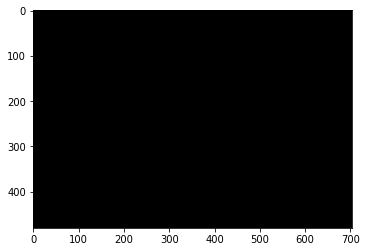

In [ ]:
folder = 'a'
image_index = 1

chunk = np.zeros((480, 704, 3))
steve = Image.fromarray((chunk * 255).astype(np.uint8))
# steve = Image.open('/content/gdrive/MyDrive/{}/{}/{}.png'.format(Frame_Storage, folder, f'{image_index:05}'))
plt.imshow(steve, interpolation='nearest')
plt.show()

/content/gdrive/MyDrive/CS236G_Project/segout_frames/a/00001_mask_0.png
/content/gdrive/MyDrive/CS236G_Project/segout_frames/a/00003_mask_0.png


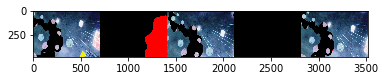

In [ ]:
folder = 'a'
image_index = 1
frame_gap = 1

a_name = '/content/gdrive/MyDrive/{}/{}/{}.png'.format(Frame_Storage, folder, f'{image_index:05}')
b_name = '/content/gdrive/MyDrive/{}/{}/{}.png'.format(Frame_Storage, folder, f'{(image_index + frame_gap):05}')
c_name = '/content/gdrive/MyDrive/{}/{}/{}.png'.format(Frame_Storage, folder, f'{(image_index + 2*frame_gap):05}')

a = np.array(Image.open(a_name))/255
b = np.array(Image.open(b_name))/255
c = np.array(Image.open(c_name))/255

a_mask = np.zeros_like(a)
count = 0
print('/content/gdrive/MyDrive/CS236G_Project/segout_frames/{}/{}_mask_{}.png'.format(folder, f'{image_index:05}', count))
while os.path.isfile('/content/gdrive/MyDrive/CS236G_Project/segout_frames/{}/{}_mask_{}.png'.format(folder, f'{image_index:05}', count)):
  addon = np.array(Image.open('/content/gdrive/MyDrive/CS236G_Project/segout_frames/{}/{}_mask_{}.png'.format(folder, f'{image_index:05}', count)).resize((704, 480)))/255
  a_mask[:,:,0] = np.maximum(a_mask[:,:,0], addon)
  count += 1

c_mask = np.zeros_like(c)
count = 0
print('/content/gdrive/MyDrive/CS236G_Project/segout_frames/{}/{}_mask_{}.png'.format(folder, f'{image_index + 2*frame_gap:05}', count))
while os.path.isfile('/content/gdrive/MyDrive/CS236G_Project/segout_frames/{}/{}_mask_{}.png'.format(folder, f'{image_index + 2*frame_gap:05}', count)):
  addon = np.array(Image.open('/content/gdrive/MyDrive/CS236G_Project/segout_frames/{}/{}_mask_{}.png'.format(folder, f'{image_index + 2*frame_gap:05}', count)).resize((704, 480)))/255
  c_mask[:,:,0] = np.maximum(c_mask[:,:,0], addon)
  count += 1

#plt.imshow(a_mask, interpolation='nearest')
#plt.show()

chunk = np.concatenate((a,a_mask,c,c_mask,b), axis = 1)
chunk_im = Image.fromarray((chunk * 255).astype(np.uint8))

plt.imshow(chunk_im, interpolation='nearest')
plt.show()
#chunk_im.save('/content/gdrive/MyDrive/{}/{}/{}.png'.format(Chunk_Storage, folder, f'{image_index:05}'))

In [ ]:
image = np.array(chunk_im)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2])).transpose((0, 3, 1, 2))
print(image.shape)
image_width = image.shape[3]
pre = image[:, :, :, :image_width // 5]
post = image[:, :, :, 2*image_width // 5:3*image_width // 5]
pre_mask = image[:, None, 0, :, image_width // 5:2*image_width // 5]
post_mask = image[:, 0, :, 3*image_width // 5:4*image_width // 5]
print(pre_mask.shape)
print(pre_mask)
#condition = torch.cat((pre, pre_mask, post, post_mask), dim=1)
real = image[:, :, :, 4*image_width // 5:]

(1, 3, 480, 3520)
(1, 1, 480, 704)
[[[[  0   0   0 ...   0   0   0]
   [  0   0   0 ...   0   0   0]
   [  0   0   0 ...   0   0   0]
   ...
   [  0   0   0 ... 255 255 255]
   [  0   0   0 ... 255 255 255]
   [  0   0   0 ... 255 255 255]]]]


This code box will search through the listed subfolders of the folder you specify, convert the frames into chunks, then save the chunks in the corresponding subfolder in the Chunk Storage folder you specified previously.

In [ ]:
frame_gap = 1
folders = ['a', 'b', 'c1', 'c2']

for folder in folders:
  frame_count = len(list(glob.iglob("/content/gdrive/MyDrive/{}/{}/*.png".format(Frame_Storage, folder))))
  todo = frame_count - 2*frame_gap
  print("Commencing on frame folder {}".format(folder))
  for i in range(1, todo+1):
    image2chunk(folder, i, frame_gap)
    if i%50 == 0:
      print("Processed {} out of {} on todo list".format(i, todo))
  print("Finished on frame folder {}".format(folder))

Code to create 5-sized chunks for mega-training

In [ ]:
frame_gap = 1
folders = ['a', 'b', 'c1', 'c2', 'kino']

for folder in folders:
  frame_count = len(list(glob.iglob("/content/gdrive/MyDrive/{}/{}/*.png".format(Frame_Storage, folder))))
  todo = frame_count - 4*frame_gap
  print("Commencing mega chunking on frame folder {}".format(folder))
  for i in range(1, todo+1):
    image25chunk(folder, i, frame_gap)
    if i%50 == 0:
      print("Processed {} out of {} on todo list".format(i, todo))
  print("Finished on frame folder {}".format(folder))

This is the code used to prepare things for DAIN to create the actual answer.

In [ ]:
source_folder = "CS236G_Project/test_frames"
output_odd = "CS236G_Project/odd_frames"
output_even = "CS236G_Project/even_frames"
folders = ['b', 'c1', 'c2', 'kino']

Since you want DAIN to make frames that already exist, split the frames into even and odd so that DAIN can fill in the appropriate frame in between.

In [ ]:
def split_even_odd(folder, image_index):
  source = '/content/gdrive/MyDrive/{}/{}/{}.png'.format(source_folder, folder, f'{image_index:05}')
  destination = None
  if image_index % 2 == 0:
    destination = '/content/gdrive/MyDrive/{}/{}/{}.png'.format(output_even, folder, f'{(image_index//2):05}')
  else:
    destination = '/content/gdrive/MyDrive/{}/{}/{}.png'.format(output_odd, folder, f'{((image_index+1)//2):05}')
  shutil.copyfile(source, destination)

In [ ]:
for folder in folders:
  frame_count = len(list(glob.iglob("/content/gdrive/MyDrive/{}/{}/*.png".format(source_folder, folder))))
  print("Commencing splitting on frame folder {}".format(folder))
  for i in range(1, frame_count+1):
    split_even_odd(folder, i)
    if i%50 == 0:
      print("Processed {} out of {} on todo list".format(i, frame_count))
  print("Finished on frame folder {}".format(folder))

At this point, you'd go over to the DAIN colab notebook and run the DAIN interpolator with the input and output folder for the frames set accordingly, you want the input folder to be where you split the odd and even frames into. Take note of where the output folder is, you'll need that for later. Remember to run the resize fix so that the frames are the same size

Define the function that will tape your DAIN frames and regular frames back together.

In [ ]:
# For the even and odd frame outputs earlier, fill them in below
def make_dain_set(image_index, folder):
  # Like here
  even_output = '/content/gdrive/MyDrive/CS236G_Project/DAIN_even'
  odd_output = '/content/gdrive/MyDrive/CS236G_Project/DAIN_odd'

  dain_index = (image_index + 1) // 2
  pre = ''
  post = ''
  dain = ''
  real = ''
  if image_index%2 == 0:
    pre = '{}/{}/{}000.png'.format(even_output, folder, f'{dain_index:05}')
    post = '{}/{}/{}000.png'.format(even_output, folder, f'{(dain_index+1):05}')
    dain = '{}/{}/{}001.png'.format(even_output, folder, f'{dain_index:05}')
    real = '{}/{}/{}000.png'.format(odd_output, folder, f'{(dain_index+1):05}')
  elif image_index%2 == 1:
    pre = '{}/{}/{}000.png'.format(odd_output, folder, f'{dain_index:05}')
    post = '{}/{}/{}000.png'.format(odd_output, folder, f'{(dain_index+1):05}')
    dain = '{}/{}/{}001.png'.format(odd_output, folder, f'{dain_index:05}')
    real = '{}/{}/{}000.png'.format(even_output, folder, f'{(dain_index):05}')
  a = np.array(Image.open(pre))/255
  b = np.array(Image.open(post))/255
  c = np.array(Image.open(dain))/255
  d = np.array(Image.open(real))/255
  chunk = np.concatenate((a,b,c,d), axis = 1)
  chunk_im = Image.fromarray((chunk * 255).astype(np.uint8))
  chunk_im.save('/content/gdrive/MyDrive/CS236G_Project/dain_train/{}/{}.png'.format(folder, f'{image_index:05}'))

Construct the DAIN chunks

In [ ]:
folders = ['a', 'b', 'c1', 'c2', 'kino']
Frame_Storage = "CS236G_Project/test_frames"
for folder in folders:
  print("Beginning on folder {}".format(folder))
  frame_count = len(list(glob.iglob("/content/gdrive/MyDrive/{}/{}/*.png".format(Frame_Storage, folder))))
  todo = frame_count - 2
  for i in range(1, todo+1):
    make_dain_set(i, folder)
    if i%50 == 0:
      print("Completed {} out of {}".format(i, todo))
  print("Finished on folder {}".format(folder))

Visualization function


In [ ]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_shifted = image_tensor
    image_unflat = image_shifted.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

Define some needed transforms for later

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

Create the training dataset

In [ ]:
# Replace Chunk_Storage with wherever you saved the actual training chunks
training_chunk_storage = 'CS236G_Project/test_chunks'

dataset = torchvision.datasets.ImageFolder('/content/gdrive/MyDrive/{}'.format(training_chunk_storage), transform=transform)
dataset_len = len(dataset)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [dataset_len - dataset_len//5, dataset_len//5])

Create training dataset for 5-chunks

In [ ]:
# Replace Chunk_Storage with wherever you saved the actual training chunks
training_chunk_storage = 'CS236G_Project/train_5chunks'

dataset = torchvision.datasets.ImageFolder('/content/gdrive/MyDrive/{}'.format(training_chunk_storage), transform=transform)
dataset_len = len(dataset)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [dataset_len - dataset_len//5, dataset_len//5])

Create dataset for DAIN version

In [ ]:
training_chunk_storage = 'CS236G_Project/dain_train'

dataset = torchvision.datasets.ImageFolder('/content/gdrive/MyDrive/{}'.format(training_chunk_storage), transform=transform)
dataset_len = len(dataset)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [dataset_len - dataset_len//5, dataset_len//5])

Create the testing dataset

In [ ]:
test_dataset = torchvision.datasets.ImageFolder('/content/gdrive/MyDrive/{}'.format(Chunk_Storage), transform=transform)

Define the training function

In [ ]:
train_gen = []
train_disc = []
rn_train_gen = []
rn_train_disc = []
val_gen = []
val_disc = []
rn_val_gen = []
rn_val_disc = []

# How often this model saves. You can modify it, as a heads up, each checkpoint takes up like 300 MB of space
save_rate = 2000

# Folder where checkpoints are saved, feel free to replace with whatever you want
save_location = "CS236G_Project"

def train(save_model=False):
    mean_generator_loss = 0
    mean_discriminator_loss = 0
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    cur_step = 0
    val_count_limit = 100

    for epoch in range(n_epochs):
        # Dataloader returns the batches
        for image, _ in tqdm(train_dataloader):
            #image_width = image.shape[3]
            #condition = image[:, :, :, :image_width // 2]
            #condition = nn.functional.interpolate(condition, size=target_shape)
            #real = image[:, :, :, image_width // 2:]
            #real = nn.functional.interpolate(real, size=target_shape)

            image_width = image.shape[3]
            pre = image[:, :, :, :image_width // 3]
            post = image[:, :, :, image_width // 3:2*image_width // 3]
            condition = torch.cat((pre, post), dim=1)
            real = image[:, :, :, 2*image_width // 3:]

            cur_batch_size = len(condition)
            condition = condition.to(device)
            real = real.to(device)

            ### Update discriminator ###
            disc_opt.zero_grad() # Zero out the gradient before backpropagation
            with torch.no_grad():
                fake = gen(condition)
            disc_fake_hat = disc(fake.detach(), condition) # Detach generator
            disc_fake_loss = adv_criterion(disc_fake_hat, torch.zeros_like(disc_fake_hat))
            disc_real_hat = disc(real, condition)
            disc_real_loss = adv_criterion(disc_real_hat, torch.ones_like(disc_real_hat))
            disc_loss = (disc_fake_loss + disc_real_loss) / 2
            disc_loss.backward(retain_graph=True) # Update gradients
            disc_opt.step() # Update optimizer

            ### Update generator ###
            gen_opt.zero_grad()
            gen_loss = get_gen_loss(gen, disc, real, condition, adv_criterion, recon_criterion, lambda_recon)
            gen_loss.backward() # Update gradients
            gen_opt.step() # Update optimizer

            # Keep track of the average discriminator loss
            mean_discriminator_loss += disc_loss.item() / display_step
            # Keep track of the average generator loss
            mean_generator_loss += gen_loss.item() / display_step

            ### Visualization code ###
            if cur_step % display_step == 0:
                if cur_step > 0:
                    print(f"Epoch {epoch}: Step {cur_step}: Generator (U-Net) loss: {mean_generator_loss}, Discriminator loss: {mean_discriminator_loss}")
                    train_gen.append(mean_generator_loss)
                    train_disc.append(mean_discriminator_loss)
                else:
                    print("Pretrained initial state")
                #show_tensor_images(condition, size=(input_dim, target_shape, target_shape))
                show_tensor_images(real, size=(3, 480, 704))
                show_tensor_images(fake, size=(3, 480, 704))

                mean_generator_loss = 0
                mean_discriminator_loss = 0

                val_count = 0
                val_mean_gen_loss = 0
                val_mean_disc_loss = 0
                for image, _ in tqdm(val_dataloader):
                  image_width = image.shape[3]
                  pre = image[:, :, :, :image_width // 3]
                  post = image[:, :, :, image_width // 3:2*image_width // 3]
                  condition = torch.cat((pre, post), dim=1)
                  real = image[:, :, :, 2*image_width // 3:]

                  cur_batch_size = len(condition)
                  condition = condition.to(device)
                  real = real.to(device)

                  disc_opt.zero_grad() # Zero out the gradient before backpropagation
                  with torch.no_grad():
                      fake = gen(condition)
                  disc_fake_hat = disc(fake.detach(), condition) # Detach generator
                  disc_fake_loss = adv_criterion(disc_fake_hat, torch.zeros_like(disc_fake_hat))
                  disc_real_hat = disc(real, condition)
                  disc_real_loss = adv_criterion(disc_real_hat, torch.ones_like(disc_real_hat))
                  disc_loss = (disc_fake_loss + disc_real_loss) / 2
                  #disc_loss.backward(retain_graph=True) # Update gradients
                  #disc_opt.step() # Update optimizer

                  ### Update generator ###
                  gen_opt.zero_grad()
                  gen_loss = get_gen_loss(gen, disc, real, condition, adv_criterion, recon_criterion, lambda_recon)
                  #gen_loss.backward() # Update gradients
                  #gen_opt.step() # Update optimizer

                  val_mean_gen_loss += gen_loss.item() / val_count_limit
                  val_mean_disc_loss += disc_loss.item() / val_count_limit
                  
                  val_count += 1
                  if val_count >= val_count_limit:
                    break
                print("Validation Set Gen Loss: {}, Validation Set Disc Loss: {}".format(val_mean_gen_loss, val_mean_disc_loss))
                val_gen.append(val_mean_gen_loss)
                val_disc.append(val_mean_disc_loss)

                # You can change save_model to True if you'd like to save the model
            if cur_step % save_rate == 0:
                if save_model:
                    torch.save({'gen': gen.state_dict(),
                        'gen_opt': gen_opt.state_dict(),
                        'disc': disc.state_dict(),
                        'disc_opt': disc_opt.state_dict()
                    }, f"/content/gdrive/MyDrive/{save_location}/opganl20_{cur_step}.pth")
            cur_step += 1

Training function for OPGAN with refinement net

In [ ]:
train_gen = []
train_disc = []
rn_train_gen = []
rn_train_disc = []
val_gen = []
val_disc = []
rn_val_gen = []
rn_val_disc = []

mean_generator_loss = 0
mean_discriminator_loss = 0
rn_mean_generator_loss = 0
rn_mean_discriminator_loss = 0

val_count = 0
val_count_limit = 100
val_mean_gen_loss = 0
val_mean_disc_loss = 0
rn_val_mean_gen_loss = 0
rn_val_mean_disc_loss = 0

# How often this model saves. You can modify it, as a heads up, each checkpoint takes up like 300 MB of space
save_rate = 2000

# Folder where checkpoints are saved, feel free to replace with whatever you want
save_location = "CS236G_Project"

def train2(save_model=False):
    mean_generator_loss = 0
    mean_discriminator_loss = 0
    rn_mean_generator_loss = 0
    rn_mean_discriminator_loss = 0
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    cur_step = 8000
    val_count_limit = 100

    for epoch in range(n_epochs):
        # Dataloader returns the batches
        for image, _ in tqdm(train_dataloader):
            #image_width = image.shape[3]
            #condition = image[:, :, :, :image_width // 2]
            #condition = nn.functional.interpolate(condition, size=target_shape)
            #real = image[:, :, :, image_width // 2:]
            #real = nn.functional.interpolate(real, size=target_shape)

            image_width = image.shape[3]
            pre = image[:, :, :, :image_width // 3]
            post = image[:, :, :, image_width // 3:2*image_width // 3]
            condition = torch.cat((pre, post), dim=1)
            real = image[:, :, :, 2*image_width // 3:]

            cur_batch_size = len(condition)
            condition = condition.to(device)
            real = real.to(device)

            dl, gl, rdl, rgl, fake, rn_fake = combo_train(condition, real)

            mean_generator_loss += gl
            mean_discriminator_loss += dl
            rn_mean_generator_loss += rgl
            rn_mean_discriminator_loss += rdl

            ### Visualization code ###
            if cur_step % display_step == 0:
                if cur_step > 0:
                    print(f"Epoch {epoch}: Step {cur_step}: Generator (U-Net) loss: {mean_generator_loss}, Discriminator loss: {mean_discriminator_loss}, R-Generator (U-Net) loss: {rn_mean_generator_loss}, R-Discriminator loss: {rn_mean_discriminator_loss},")
                    train_gen.append(mean_generator_loss)
                    train_disc.append(mean_discriminator_loss)
                    rn_train_gen.append(rn_mean_generator_loss)
                    rn_train_disc.append(rn_mean_discriminator_loss)
                else:
                    print("Pretrained initial state")
                #show_tensor_images(condition, size=(input_dim, target_shape, target_shape))
                show_tensor_images(real, size=(3, 480, 704))
                show_tensor_images(fake, size=(3, 480, 704))
                show_tensor_images(rn_fake, size=(3, 480, 704))

                mean_generator_loss = 0
                mean_discriminator_loss = 0
                rn_mean_generator_loss = 0
                rn_mean_discriminator_loss = 0

                val_count = 0
                val_mean_gen_loss = 0
                val_mean_disc_loss = 0
                rn_val_mean_gen_loss = 0
                rn_val_mean_disc_loss = 0
                for image, _ in tqdm(val_dataloader):
                  image_width = image.shape[3]
                  pre = image[:, :, :, :image_width // 3]
                  post = image[:, :, :, image_width // 3:2*image_width // 3]
                  condition = torch.cat((pre, post), dim=1)
                  real = image[:, :, :, 2*image_width // 3:]

                  cur_batch_size = len(condition)
                  condition = condition.to(device)
                  real = real.to(device)

                  dl, gl, rdl, rgl, fake, rn_fake = combo_train(condition, real, val=True, mean_count = val_count_limit)

                  val_mean_gen_loss += gl
                  val_mean_disc_loss += dl
                  rn_val_mean_gen_loss += rgl
                  rn_val_mean_disc_loss += rdl
                  
                  val_count += 1
                  if val_count >= val_count_limit:
                    break
                print("Validation Set Gen Loss: {}, Validation Set Disc Loss: {}, Validation Set R-Gen Loss: {}, Validation Set R-Disc Loss: {}".format(val_mean_gen_loss, val_mean_disc_loss, rn_val_mean_gen_loss, rn_val_mean_disc_loss))
                val_gen.append(val_mean_gen_loss)
                val_disc.append(val_mean_disc_loss)
                rn_val_gen.append(rn_val_mean_gen_loss)
                rn_val_disc.append(rn_val_mean_disc_loss)

                # You can change save_model to True if you'd like to save the model
            if cur_step % save_rate == 0:
                if save_model:
                    torch.save({'gen': gen.state_dict(),
                        'gen_opt': gen_opt.state_dict(),
                        'disc': disc.state_dict(),
                        'disc_opt': disc_opt.state_dict()
                    }, f"/content/gdrive/MyDrive/{save_location}/orig_opgan_{cur_step}.pth")
                    torch.save({'rn_gen': rn_gen.state_dict(),
                        'rn_gen_opt': rn_gen_opt.state_dict(),
                        'rn_disc': rn_disc.state_dict(),
                        'rn_disc_opt': rn_disc_opt.state_dict()
                    }, f"/content/gdrive/MyDrive/{save_location}/rn_opgan_{cur_step}.pth")
            cur_step += 1

Condensor function that performs training over the combined base and refinement model

In [ ]:
def combo_train(condition, real, val=False, mean_count = None):
  ### Update discriminator ###
  disc_opt.zero_grad() # Zero out the gradient before backpropagation
  with torch.no_grad():
      fake = gen(condition)
  disc_fake_hat = disc(fake.detach(), condition) # Detach generator
  disc_fake_loss = adv_criterion(disc_fake_hat, torch.zeros_like(disc_fake_hat))
  disc_real_hat = disc(real, condition)
  disc_real_loss = adv_criterion(disc_real_hat, torch.ones_like(disc_real_hat))
  disc_loss = (disc_fake_loss + disc_real_loss) / 2
  disc_loss.backward(retain_graph=True) # Update gradients
  disc_opt.step() # Update optimizer

  ### Update generator ###
  gen_opt.zero_grad()
  gen_loss = get_gen_loss(gen, disc, real, condition, adv_criterion, recon_criterion, lambda_recon)
  gen_loss.backward() # Update gradients
  gen_opt.step() # Update optimizer

  # Keep track of the average discriminator loss
  # mean_discriminator_loss += disc_loss.item() / display_step
  # Keep track of the average generator loss
  # mean_generator_loss += gen_loss.item() / display_step

  rn_condition = torch.cat((fake, condition), dim=1)
  rn_disc_opt.zero_grad()
  with torch.no_grad():
    rn_fake = rn_gen(rn_condition)
  rn_disc_fake_hat = rn_disc(rn_fake.detach(), rn_condition) # Detach generator
  rn_disc_fake_loss = adv_criterion(rn_disc_fake_hat, torch.zeros_like(rn_disc_fake_hat))
  rn_disc_real_hat = rn_disc(real, rn_condition)
  rn_disc_real_loss = adv_criterion(rn_disc_real_hat, torch.ones_like(rn_disc_real_hat))
  rn_disc_loss = (rn_disc_fake_loss + rn_disc_real_loss) / 2
  rn_disc_loss.backward(retain_graph=True) # Update gradients
  rn_disc_opt.step() # Update optimizer

  rn_gen_opt.zero_grad()
  rn_gen_loss = get_gen_loss(rn_gen, rn_disc, real, rn_condition, adv_criterion, recon_criterion, lambda_recon)
  rn_gen_loss.backward() # Update gradients
  rn_gen_opt.step() # Update optimizer

  # rn_mean_discriminator_loss += rn_disc_loss.item() / display_step
  # Keep track of the average generator loss
  # rn_mean_generator_loss += rn_gen_loss.item() / display_step
  if val:
    return disc_loss.item() / mean_count, gen_loss.item() / mean_count, rn_disc_loss.item() / mean_count, rn_gen_loss.item() / mean_count, fake, rn_fake
  else:
    return disc_loss.item() / display_step, gen_loss.item() / display_step, rn_disc_loss.item() / display_step, rn_gen_loss.item() / display_step, fake, rn_fake

Training function for the 5-frame version of the model

In [ ]:
train_gen = []
train_disc = []
rn_train_gen = []
rn_train_disc = []
val_gen = []
val_disc = []
rn_val_gen = []
rn_val_disc = []

mean_generator_loss = 0
mean_discriminator_loss = 0
rn_mean_generator_loss = 0
rn_mean_discriminator_loss = 0

val_count = 0
val_mean_gen_loss = 0
val_mean_disc_loss = 0
rn_val_mean_gen_loss = 0
rn_val_mean_disc_loss = 0

# How often this model saves. You can modify it, as a heads up, each checkpoint takes up like 300 MB of space
save_rate = 2000

# Folder where checkpoints are saved, feel free to replace with whatever you want
save_location = "CS236G_Project"

def train3(save_model=False):
    mean_generator_loss = 0
    mean_discriminator_loss = 0
    rn_mean_generator_loss = 0
    rn_mean_discriminator_loss = 0
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    cur_step = 0
    val_count_limit = 100

    for epoch in range(n_epochs):
        # Dataloader returns the batches
        for image, _ in tqdm(train_dataloader):
            #image_width = image.shape[3]
            #condition = image[:, :, :, :image_width // 2]
            #condition = nn.functional.interpolate(condition, size=target_shape)
            #real = image[:, :, :, image_width // 2:]
            #real = nn.functional.interpolate(real, size=target_shape)

            # Note that for 5-chunks the frames are in order!
            image_width = image.shape[3]
            pre = image[:, :, :, :image_width // 5]
            post = image[:, :, :, 4*image_width // 5:]
            condition_2 = torch.cat((pre, post), dim=1)
            real_1 = image[:, :, :, image_width // 5: 2*image_width // 5]
            real_2 = image[:, :, :, 2*image_width // 5: 3*image_width // 5]
            real_3 = image[:, :, :, 3*image_width // 5: 4*image_width // 5]

            cur_batch_size = len(condition_2)
            pre = pre.to(device)
            post = post.to(device)
            condition_2 = condition_2.to(device)
            real_1 = real_1.to(device)
            real_2 = real_2.to(device)
            real_3 = real_3.to(device)

            # For the discriminator and generator, they will go through 3 updates, one for each of the 3 frames

            dl, gl, rdl, rgl, fake_2, rn_fake_2 = combo_train(condition_2, real_2)

            mean_generator_loss += gl
            mean_discriminator_loss += dl
            rn_mean_generator_loss += rgl
            rn_mean_discriminator_loss += rdl

            # mid = rn_fake_2.detach()
            mid = rn_fake_2
            condition_1 = torch.cat((pre, mid), dim=1)
            condition_3 = torch.cat((mid, post), dim=1)

            dl, gl, rdl, rgl, fake_1, rn_fake_1 = combo_train(condition_1, real_1)

            mean_generator_loss += gl
            mean_discriminator_loss += dl
            rn_mean_generator_loss += rgl
            rn_mean_discriminator_loss += rdl

            dl, gl, rdl, rgl, fake_3, rn_fake_3 = combo_train(condition_3, real_3)

            mean_generator_loss += gl
            mean_discriminator_loss += dl
            rn_mean_generator_loss += rgl
            rn_mean_discriminator_loss += rdl

            ### Visualization code ###
            if cur_step % display_step == 0:
                if cur_step > 0:
                    print(f"Epoch {epoch}: Step {cur_step}: Generator (U-Net) loss: {mean_generator_loss}, Discriminator loss: {mean_discriminator_loss}, R-Generator (U-Net) loss: {rn_mean_generator_loss}, R-Discriminator loss: {rn_mean_discriminator_loss},")
                    train_gen.append(mean_generator_loss)
                    train_disc.append(mean_discriminator_loss)
                    rn_train_gen.append(rn_mean_generator_loss)
                    rn_train_disc.append(rn_mean_discriminator_loss)
                else:
                    print("Pretrained initial state")
                #show_tensor_images(condition, size=(input_dim, target_shape, target_shape))
                show_tensor_images(pre, size=(3, 480, 704))

                show_tensor_images(real_1, size=(3, 480, 704))
                show_tensor_images(fake_1, size=(3, 480, 704))
                show_tensor_images(rn_fake_1, size=(3, 480, 704))

                show_tensor_images(real_2, size=(3, 480, 704))
                show_tensor_images(fake_2, size=(3, 480, 704))
                show_tensor_images(rn_fake_2, size=(3, 480, 704))

                show_tensor_images(real_3, size=(3, 480, 704))
                show_tensor_images(fake_3, size=(3, 480, 704))
                show_tensor_images(rn_fake_3, size=(3, 480, 704))

                show_tensor_images(post, size=(3, 480, 704))

                mean_generator_loss = 0
                mean_discriminator_loss = 0
                rn_mean_generator_loss = 0
                rn_mean_discriminator_loss = 0

                val_count = 0
                val_mean_gen_loss = 0
                val_mean_disc_loss = 0
                rn_val_mean_gen_loss = 0
                rn_val_mean_disc_loss = 0
                for image, _ in tqdm(val_dataloader):
                  image_width = image.shape[3]
                  pre = image[:, :, :, :image_width // 5]
                  post = image[:, :, :, 4*image_width // 5:]
                  condition_2 = torch.cat((pre, post), dim=1)
                  real_1 = image[:, :, :, image_width // 5: 2*image_width // 5]
                  real_2 = image[:, :, :, 2*image_width // 5: 3*image_width // 5]
                  real_3 = image[:, :, :, 3*image_width // 5: 4*image_width // 5]

                  cur_batch_size = len(condition_2)
                  pre = pre.to(device)
                  post = post.to(device)
                  condition_2 = condition_2.to(device)
                  real_1 = real_1.to(device)
                  real_2 = real_2.to(device)
                  real_3 = real_3.to(device)

                  dl, gl, rdl, rgl, fake, rn_fake_2 = combo_train(condition_2, real_2, val=True, mean_count = val_count_limit)

                  val_mean_gen_loss += gl
                  val_mean_disc_loss += dl
                  rn_val_mean_gen_loss += rgl
                  rn_val_mean_disc_loss += rdl

                  # You might or might not want to detach rn_fake_2 to create the mid image
                  # It runs if we detach it, I don't know if we'll get a mem error if we don't
                  # mid = rn_fake_2.detach()
                  mid = rn_fake_2

                  # A side note on memory errors, it appears that Colab is giving me whichever GPU is free, depending on what
                  # I get, the speed of training varies by up to a factor of 2.5
                  # The memory error tends to occur when training is run multiple times, a quick fix is to factory reset the runtime
                  # Perhaps there is some kind of memory leak that I am not addressing

                  condition_1 = torch.cat((pre, mid), dim=1)
                  condition_3 = torch.cat((mid, post), dim=1)

                  dl, gl, rdl, rgl, fake, rn_fake_2 = combo_train(condition_1, real_1, val=True, mean_count = val_count_limit)

                  val_mean_gen_loss += gl
                  val_mean_disc_loss += dl
                  rn_val_mean_gen_loss += rgl
                  rn_val_mean_disc_loss += rdl

                  dl, gl, rdl, rgl, fake, rn_fake_2 = combo_train(condition_3, real_3, val=True, mean_count = val_count_limit)

                  val_mean_gen_loss += gl
                  val_mean_disc_loss += dl
                  rn_val_mean_gen_loss += rgl
                  rn_val_mean_disc_loss += rdl
                  
                  val_count += 1
                  if val_count >= val_count_limit:
                    break
                print("Validation Set Gen Loss: {}, Validation Set Disc Loss: {}, Validation Set R-Gen Loss: {}, Validation Set R-Disc Loss: {}".format(val_mean_gen_loss, val_mean_disc_loss, rn_val_mean_gen_loss, rn_val_mean_disc_loss))
                val_gen.append(val_mean_gen_loss)
                val_disc.append(val_mean_disc_loss)
                rn_val_gen.append(rn_val_mean_gen_loss)
                rn_val_disc.append(rn_val_mean_disc_loss)

                # You can change save_model to True if you'd like to save the model
            if cur_step % save_rate == 0:
                if save_model:
                    torch.save({'gen': gen.state_dict(),
                        'gen_opt': gen_opt.state_dict(),
                        'disc': disc.state_dict(),
                        'disc_opt': disc_opt.state_dict()
                    }, f"/content/gdrive/MyDrive/{save_location}/orig_Vopgan_{cur_step}.pth")
                    torch.save({'rn_gen': rn_gen.state_dict(),
                        'rn_gen_opt': rn_gen_opt.state_dict(),
                        'rn_disc': rn_disc.state_dict(),
                        'rn_disc_opt': rn_disc_opt.state_dict()
                    }, f"/content/gdrive/MyDrive/{save_location}/rn_Vopgan_{cur_step}.pth")
            cur_step += 1

DAIN-based model training function

In [ ]:
train_gen = []
train_disc = []
rn_train_gen = []
rn_train_disc = []
val_gen = []
val_disc = []
rn_val_gen = []
rn_val_disc = []

mean_generator_loss = 0
mean_discriminator_loss = 0
rn_mean_generator_loss = 0
rn_mean_discriminator_loss = 0

val_count = 0
val_count_limit = 100
val_mean_gen_loss = 0
val_mean_disc_loss = 0
rn_val_mean_gen_loss = 0
rn_val_mean_disc_loss = 0

# How often this model saves. You can modify it, as a heads up, each checkpoint takes up like 300 MB of space
save_rate = 2000

# Folder where checkpoints are saved, feel free to replace with whatever you want
save_location = "CS236G_Project"

def dain_train(save_model=False):
    mean_generator_loss = 0
    mean_discriminator_loss = 0
    rn_mean_generator_loss = 0
    rn_mean_discriminator_loss = 0
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    cur_step = 0
    val_count_limit = 100

    for epoch in range(n_epochs):
        # Dataloader returns the batches
        for image, _ in tqdm(train_dataloader):
            #image_width = image.shape[3]
            #condition = image[:, :, :, :image_width // 2]
            #condition = nn.functional.interpolate(condition, size=target_shape)
            #real = image[:, :, :, image_width // 2:]
            #real = nn.functional.interpolate(real, size=target_shape)

            image_width = image.shape[3]
            pre = image[:, :, :, :image_width // 4]
            post = image[:, :, :, image_width // 4:2*image_width // 4]
            dain = image[:, :, :, 2*image_width // 4:3*image_width // 4]
            rn_condition = torch.cat((pre, dain, post), dim=1)
            real = image[:, :, :, 3*image_width // 4:]

            cur_batch_size = len(rn_condition)
            rn_condition = rn_condition.to(device)
            real = real.to(device)
            dain = dain.to(device)

            rn_disc_opt.zero_grad()
            with torch.no_grad():
              rn_fake = rn_gen(rn_condition)
            rn_disc_fake_hat = rn_disc(rn_fake.detach(), rn_condition) # Detach generator
            rn_disc_fake_loss = adv_criterion(rn_disc_fake_hat, torch.zeros_like(rn_disc_fake_hat))
            rn_disc_real_hat = rn_disc(real, rn_condition)
            rn_disc_real_loss = adv_criterion(rn_disc_real_hat, torch.ones_like(rn_disc_real_hat))
            rn_disc_loss = (rn_disc_fake_loss + rn_disc_real_loss) / 2
            rn_disc_loss.backward(retain_graph=True) # Update gradients
            rn_disc_opt.step() # Update optimizer

            rn_gen_opt.zero_grad()
            rn_gen_loss = get_gen_loss(rn_gen, rn_disc, real, rn_condition, adv_criterion, recon_criterion, lambda_recon)
            rn_gen_loss.backward() # Update gradients
            rn_gen_opt.step() # Update optimizer

            rn_mean_generator_loss += rn_gen_loss.item() / display_step
            rn_mean_discriminator_loss += rn_disc_loss.item() / display_step

            ### Visualization code ###
            if cur_step % display_step == 0:
                if cur_step > 0:
                    print(f"Epoch {epoch}: Step {cur_step}: Generator (U-Net) loss: {mean_generator_loss}, Discriminator loss: {mean_discriminator_loss}, R-Generator (U-Net) loss: {rn_mean_generator_loss}, R-Discriminator loss: {rn_mean_discriminator_loss},")
                    train_gen.append(mean_generator_loss)
                    train_disc.append(mean_discriminator_loss)
                    rn_train_gen.append(rn_mean_generator_loss)
                    rn_train_disc.append(rn_mean_discriminator_loss)
                else:
                    print("Pretrained initial state")
                #show_tensor_images(condition, size=(input_dim, target_shape, target_shape))
                show_tensor_images(real, size=(3, 480, 704))
                show_tensor_images(dain, size=(3, 480, 704))
                show_tensor_images(rn_fake, size=(3, 480, 704))

                mean_generator_loss = 0
                mean_discriminator_loss = 0
                rn_mean_generator_loss = 0
                rn_mean_discriminator_loss = 0

                val_count = 0
                val_mean_gen_loss = 0
                val_mean_disc_loss = 0
                rn_val_mean_gen_loss = 0
                rn_val_mean_disc_loss = 0
                for image, _ in tqdm(val_dataloader):
                  image_width = image.shape[3]
                  pre = image[:, :, :, :image_width // 4]
                  post = image[:, :, :, image_width // 4:2*image_width // 4]
                  dain = image[:, :, :, 2*image_width // 4:3*image_width // 4]
                  rn_condition = torch.cat((pre, dain, post), dim=1)
                  real = image[:, :, :, 3*image_width // 4:]

                  cur_batch_size = len(rn_condition)
                  rn_condition = rn_condition.to(device)
                  real = real.to(device)
                  dain = dain.to(device)

                  rn_disc_opt.zero_grad()
                  with torch.no_grad():
                    rn_fake = rn_gen(rn_condition)
                  rn_disc_fake_hat = rn_disc(rn_fake.detach(), rn_condition) # Detach generator
                  rn_disc_fake_loss = adv_criterion(rn_disc_fake_hat, torch.zeros_like(rn_disc_fake_hat))
                  rn_disc_real_hat = rn_disc(real, rn_condition)
                  rn_disc_real_loss = adv_criterion(rn_disc_real_hat, torch.ones_like(rn_disc_real_hat))
                  rn_disc_loss = (rn_disc_fake_loss + rn_disc_real_loss) / 2
                  rn_disc_loss.backward(retain_graph=True) # Update gradients
                  rn_disc_opt.step() # Update optimizer

                  rn_gen_opt.zero_grad()
                  rn_gen_loss = get_gen_loss(rn_gen, rn_disc, real, rn_condition, adv_criterion, recon_criterion, lambda_recon)
                  rn_gen_loss.backward() # Update gradients
                  rn_gen_opt.step() # Update optimizer

                  rn_val_mean_gen_loss += rn_gen_loss.item() / val_count_limit
                  rn_val_mean_disc_loss += rn_disc_loss.item() / val_count_limit
                  
                  val_count += 1
                  if val_count >= val_count_limit:
                    break
                print("Validation Set Gen Loss: {}, Validation Set Disc Loss: {}, Validation Set R-Gen Loss: {}, Validation Set R-Disc Loss: {}".format(val_mean_gen_loss, val_mean_disc_loss, rn_val_mean_gen_loss, rn_val_mean_disc_loss))
                val_gen.append(val_mean_gen_loss)
                val_disc.append(val_mean_disc_loss)
                rn_val_gen.append(rn_val_mean_gen_loss)
                rn_val_disc.append(rn_val_mean_disc_loss)

                # You can change save_model to True if you'd like to save the model
            if cur_step % save_rate == 0:
                if save_model:
                    torch.save({'rn_gen': rn_gen.state_dict(),
                        'rn_gen_opt': rn_gen_opt.state_dict(),
                        'rn_disc': rn_disc.state_dict(),
                        'rn_disc_opt': rn_disc_opt.state_dict()
                    }, f"/content/gdrive/MyDrive/{save_location}/Dopgan_{cur_step}.pth")
            cur_step += 1

Masked version of function

In [ ]:
train_gen = []
train_disc = []
rn_train_gen = []
rn_train_disc = []
val_gen = []
val_disc = []
rn_val_gen = []
rn_val_disc = []

mean_generator_loss = 0
mean_discriminator_loss = 0
rn_mean_generator_loss = 0
rn_mean_discriminator_loss = 0

val_count = 0
val_count_limit = 100
val_mean_gen_loss = 0
val_mean_disc_loss = 0
rn_val_mean_gen_loss = 0
rn_val_mean_disc_loss = 0

# How often this model saves. You can modify it, as a heads up, each checkpoint takes up like 300 MB of space
save_rate = 2000

# Folder where checkpoints are saved, feel free to replace with whatever you want
save_location = "CS236G_Project"

def mask_train(save_model=False):
    mean_generator_loss = 0
    mean_discriminator_loss = 0
    rn_mean_generator_loss = 0
    rn_mean_discriminator_loss = 0
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    cur_step = 8000
    val_count_limit = 100

    for epoch in range(n_epochs):
        # Dataloader returns the batches
        for image, _ in tqdm(train_dataloader):
            #image_width = image.shape[3]
            #condition = image[:, :, :, :image_width // 2]
            #condition = nn.functional.interpolate(condition, size=target_shape)
            #real = image[:, :, :, image_width // 2:]
            #real = nn.functional.interpolate(real, size=target_shape)

            image_width = image.shape[3]
            pre = image[:, :, :, :image_width // 5]
            post = image[:, :, :, 2*image_width // 5:3*image_width // 5]
            pre_mask = image[:, 0, :, image_width // 5:2*image_width // 5]
            post_mask = image[:, 0, :, 3*image_width // 5:4*image_width // 5]
            condition = torch.cat((pre, pre_mask, post, post_mask), dim=1)
            real = image[:, :, :, 4*image_width // 5:]

            cur_batch_size = len(condition)
            condition = condition.to(device)
            real = real.to(device)

            dl, gl, rdl, rgl, fake, rn_fake = combo_train(condition, real)

            mean_generator_loss += gl
            mean_discriminator_loss += dl
            rn_mean_generator_loss += rgl
            rn_mean_discriminator_loss += rdl

            ### Visualization code ###
            if cur_step % display_step == 0:
                if cur_step > 0:
                    print(f"Epoch {epoch}: Step {cur_step}: Generator (U-Net) loss: {mean_generator_loss}, Discriminator loss: {mean_discriminator_loss}, R-Generator (U-Net) loss: {rn_mean_generator_loss}, R-Discriminator loss: {rn_mean_discriminator_loss},")
                    train_gen.append(mean_generator_loss)
                    train_disc.append(mean_discriminator_loss)
                    rn_train_gen.append(rn_mean_generator_loss)
                    rn_train_disc.append(rn_mean_discriminator_loss)
                else:
                    print("Pretrained initial state")
                #show_tensor_images(condition, size=(input_dim, target_shape, target_shape))
                show_tensor_images(real, size=(3, 480, 704))
                show_tensor_images(fake, size=(3, 480, 704))
                show_tensor_images(rn_fake, size=(3, 480, 704))

                mean_generator_loss = 0
                mean_discriminator_loss = 0
                rn_mean_generator_loss = 0
                rn_mean_discriminator_loss = 0

                val_count = 0
                val_mean_gen_loss = 0
                val_mean_disc_loss = 0
                rn_val_mean_gen_loss = 0
                rn_val_mean_disc_loss = 0
                for image, _ in tqdm(val_dataloader):
                  image_width = image.shape[3]
                  pre = image[:, :, :, :image_width // 5]
                  post = image[:, :, :, 2*image_width // 5:3*image_width // 5]
                  pre_mask = image[:, 0, :, image_width // 5:2*image_width // 5]
                  post_mask = image[:, 0, :, 3*image_width // 5:4*image_width // 5]
                  condition = torch.cat((pre, pre_mask, post, post_mask), dim=1)
                  real = image[:, :, :, 4*image_width // 5:]

                  cur_batch_size = len(condition)
                  condition = condition.to(device)
                  real = real.to(device)

                  dl, gl, rdl, rgl, fake, rn_fake = combo_train(condition, real, val=True, mean_count = val_count_limit)

                  val_mean_gen_loss += gl
                  val_mean_disc_loss += dl
                  rn_val_mean_gen_loss += rgl
                  rn_val_mean_disc_loss += rdl
                  
                  val_count += 1
                  if val_count >= val_count_limit:
                    break
                print("Validation Set Gen Loss: {}, Validation Set Disc Loss: {}, Validation Set R-Gen Loss: {}, Validation Set R-Disc Loss: {}".format(val_mean_gen_loss, val_mean_disc_loss, rn_val_mean_gen_loss, rn_val_mean_disc_loss))
                val_gen.append(val_mean_gen_loss)
                val_disc.append(val_mean_disc_loss)
                rn_val_gen.append(rn_val_mean_gen_loss)
                rn_val_disc.append(rn_val_mean_disc_loss)

                # You can change save_model to True if you'd like to save the model
            if cur_step % save_rate == 0:
                if save_model:
                    torch.save({'gen': gen.state_dict(),
                        'gen_opt': gen_opt.state_dict(),
                        'disc': disc.state_dict(),
                        'disc_opt': disc_opt.state_dict()
                    }, f"/content/gdrive/MyDrive/{save_location}/orig_opgan_{cur_step}.pth")
                    torch.save({'rn_gen': rn_gen.state_dict(),
                        'rn_gen_opt': rn_gen_opt.state_dict(),
                        'rn_disc': rn_disc.state_dict(),
                        'rn_disc_opt': rn_disc_opt.state_dict()
                    }, f"/content/gdrive/MyDrive/{save_location}/rn_opgan_{cur_step}.pth")
            cur_step += 1

In [ ]:
train_gen = []
train_disc = []
rn_train_gen = []
rn_train_disc = []
val_gen = []
val_disc = []
rn_val_gen = []
rn_val_disc = []

mean_generator_loss = 0
mean_discriminator_loss = 0
rn_mean_generator_loss = 0
rn_mean_discriminator_loss = 0

val_count = 0
val_count_limit = 100
val_mean_gen_loss = 0
val_mean_disc_loss = 0
rn_val_mean_gen_loss = 0
rn_val_mean_disc_loss = 0

# How often this model saves. You can modify it, as a heads up, each checkpoint takes up like 300 MB of space
save_rate = 2000

# Folder where checkpoints are saved, feel free to replace with whatever you want
save_location = "CS236G_Project"

def mask_train(save_model=False):
    mean_generator_loss = 0
    mean_discriminator_loss = 0
    rn_mean_generator_loss = 0
    rn_mean_discriminator_loss = 0
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    cur_step = 0
    val_count_limit = 100

    for epoch in range(n_epochs):
        # Dataloader returns the batches
        for image, _ in tqdm(train_dataloader):
            #image_width = image.shape[3]
            #condition = image[:, :, :, :image_width // 2]
            #condition = nn.functional.interpolate(condition, size=target_shape)
            #real = image[:, :, :, image_width // 2:]
            #real = nn.functional.interpolate(real, size=target_shape)

            image_width = image.shape[3]
            pre = image[:, :, :, :image_width // 5]
            post = image[:, :, :, 2*image_width // 5:3*image_width // 5]
            pre_mask = image[:, 0, :, image_width // 5:2*image_width // 5]
            post_mask = image[:, 0, :, 3*image_width // 5:4*image_width // 5]
            condition = torch.cat((pre, pre_mask, post, post_mask), dim=1)
            real = image[:, :, :, 4*image_width // 5:]

            cur_batch_size = len(rn_condition)
            rn_condition = rn_condition.to(device)
            real = real.to(device)
            dain = dain.to(device)

            rn_disc_opt.zero_grad()
            with torch.no_grad():
              rn_fake = rn_gen(rn_condition)
            rn_disc_fake_hat = rn_disc(rn_fake.detach(), rn_condition) # Detach generator
            rn_disc_fake_loss = adv_criterion(rn_disc_fake_hat, torch.zeros_like(rn_disc_fake_hat))
            rn_disc_real_hat = rn_disc(real, rn_condition)
            rn_disc_real_loss = adv_criterion(rn_disc_real_hat, torch.ones_like(rn_disc_real_hat))
            rn_disc_loss = (rn_disc_fake_loss + rn_disc_real_loss) / 2
            rn_disc_loss.backward(retain_graph=True) # Update gradients
            rn_disc_opt.step() # Update optimizer

            rn_gen_opt.zero_grad()
            rn_gen_loss = get_gen_loss(rn_gen, rn_disc, real, rn_condition, adv_criterion, recon_criterion, lambda_recon)
            rn_gen_loss.backward() # Update gradients
            rn_gen_opt.step() # Update optimizer

            rn_mean_generator_loss += rn_gen_loss.item() / display_step
            rn_mean_discriminator_loss += rn_disc_loss.item() / display_step

            ### Visualization code ###
            if cur_step % display_step == 0:
                if cur_step > 0:
                    print(f"Epoch {epoch}: Step {cur_step}: Generator (U-Net) loss: {mean_generator_loss}, Discriminator loss: {mean_discriminator_loss}, R-Generator (U-Net) loss: {rn_mean_generator_loss}, R-Discriminator loss: {rn_mean_discriminator_loss},")
                    train_gen.append(mean_generator_loss)
                    train_disc.append(mean_discriminator_loss)
                    rn_train_gen.append(rn_mean_generator_loss)
                    rn_train_disc.append(rn_mean_discriminator_loss)
                else:
                    print("Pretrained initial state")
                #show_tensor_images(condition, size=(input_dim, target_shape, target_shape))
                show_tensor_images(real, size=(3, 480, 704))
                show_tensor_images(dain, size=(3, 480, 704))
                show_tensor_images(rn_fake, size=(3, 480, 704))

                mean_generator_loss = 0
                mean_discriminator_loss = 0
                rn_mean_generator_loss = 0
                rn_mean_discriminator_loss = 0

                val_count = 0
                val_mean_gen_loss = 0
                val_mean_disc_loss = 0
                rn_val_mean_gen_loss = 0
                rn_val_mean_disc_loss = 0
                for image, _ in tqdm(val_dataloader):
                  image_width = image.shape[3]
                  pre = image[:, :, :, :image_width // 4]
                  post = image[:, :, :, image_width // 4:2*image_width // 4]
                  dain = image[:, :, :, 2*image_width // 4:3*image_width // 4]
                  rn_condition = torch.cat((pre, dain, post), dim=1)
                  real = image[:, :, :, 3*image_width // 4:]

                  cur_batch_size = len(rn_condition)
                  rn_condition = rn_condition.to(device)
                  real = real.to(device)
                  dain = dain.to(device)

                  rn_disc_opt.zero_grad()
                  with torch.no_grad():
                    rn_fake = rn_gen(rn_condition)
                  rn_disc_fake_hat = rn_disc(rn_fake.detach(), rn_condition) # Detach generator
                  rn_disc_fake_loss = adv_criterion(rn_disc_fake_hat, torch.zeros_like(rn_disc_fake_hat))
                  rn_disc_real_hat = rn_disc(real, rn_condition)
                  rn_disc_real_loss = adv_criterion(rn_disc_real_hat, torch.ones_like(rn_disc_real_hat))
                  rn_disc_loss = (rn_disc_fake_loss + rn_disc_real_loss) / 2
                  rn_disc_loss.backward(retain_graph=True) # Update gradients
                  rn_disc_opt.step() # Update optimizer

                  rn_gen_opt.zero_grad()
                  rn_gen_loss = get_gen_loss(rn_gen, rn_disc, real, rn_condition, adv_criterion, recon_criterion, lambda_recon)
                  rn_gen_loss.backward() # Update gradients
                  rn_gen_opt.step() # Update optimizer

                  rn_val_mean_gen_loss += rn_gen_loss.item() / val_count_limit
                  rn_val_mean_disc_loss += rn_disc_loss.item() / val_count_limit
                  
                  val_count += 1
                  if val_count >= val_count_limit:
                    break
                print("Validation Set Gen Loss: {}, Validation Set Disc Loss: {}, Validation Set R-Gen Loss: {}, Validation Set R-Disc Loss: {}".format(val_mean_gen_loss, val_mean_disc_loss, rn_val_mean_gen_loss, rn_val_mean_disc_loss))
                val_gen.append(val_mean_gen_loss)
                val_disc.append(val_mean_disc_loss)
                rn_val_gen.append(rn_val_mean_gen_loss)
                rn_val_disc.append(rn_val_mean_disc_loss)

                # You can change save_model to True if you'd like to save the model
            if cur_step % save_rate == 0:
                if save_model:
                    torch.save({'rn_gen': rn_gen.state_dict(),
                        'rn_gen_opt': rn_gen_opt.state_dict(),
                        'rn_disc': rn_disc.state_dict(),
                        'rn_disc_opt': rn_disc_opt.state_dict()
                    }, f"/content/gdrive/MyDrive/{save_location}/Dopgan_{cur_step}.pth")
            cur_step += 1

Define the testing function

In [ ]:
def test_generator(test_count_limit = 300):
  test_count = 0
  test_mean_gen_loss = 0
  test_mean_disc_loss = 0
  test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
  for image, _ in tqdm(test_dataloader):
    image_width = image.shape[3]
    pre = image[:, :, :, :image_width // 3]
    post = image[:, :, :, image_width // 3:2*image_width // 3]
    condition = torch.cat((pre, post), dim=1)
    real = image[:, :, :, 2*image_width // 3:]

    cur_batch_size = len(condition)
    condition = condition.to(device)
    real = real.to(device)

    disc_opt.zero_grad() # Zero out the gradient before backpropagation
    with torch.no_grad():
        fake = gen(condition)
    disc_fake_hat = disc(fake.detach(), condition) # Detach generator
    disc_fake_loss = adv_criterion(disc_fake_hat, torch.zeros_like(disc_fake_hat))
    disc_real_hat = disc(real, condition)
    disc_real_loss = adv_criterion(disc_real_hat, torch.ones_like(disc_real_hat))
    disc_loss = (disc_fake_loss + disc_real_loss) / 2

    gen_opt.zero_grad()
    gen_loss = get_gen_loss(gen, disc, real, condition, adv_criterion, recon_criterion, lambda_recon)

    test_mean_gen_loss += gen_loss.item() / test_count_limit
    test_mean_disc_loss += disc_loss.item() / test_count_limit

    if test_count % 10 == 0:
      show_tensor_images(real, size=(3, 480, 704))
      show_tensor_images(fake, size=(3, 480, 704))

    test_count += 1
    if test_count >= test_count_limit:
      break
  print("Test Set Gen Loss: {}, Test Set Disc Loss: {}".format(test_mean_gen_loss, test_mean_disc_loss))

Run the training function

In [ ]:
train(save_model=True)

Run training on combined base and refinement model (FinniGAN model)

In [ ]:
train2(save_model = True)

Run training on 5-frame model (VOPGAN)

In [ ]:
train3(save_model = False)

Run training on DAIN version of the model (DOPGAN)

In [ ]:
dain_train(save_model = True)

Plot Generator loss

In [ ]:
train_gen_spaced = np.zeros((len(train_gen), 2))
for i in range(len(train_gen)):
  train_gen_spaced[i,0] = (i+1)*500
  train_gen_spaced[i,1] = train_gen[i]

val_gen_spaced = np.zeros((len(val_gen), 2))
for i in range(len(val_gen)):
  val_gen_spaced[i,0] = i*500
  val_gen_spaced[i,1] = val_gen[i]

plt.plot(train_gen_spaced[:,0], train_gen_spaced[:,1])
plt.plot(val_gen_spaced[:,0], val_gen_spaced[:,1])

Plot Discriminator loss

In [ ]:
train_disc_spaced = np.zeros((len(train_disc), 2))
for i in range(len(train_disc)):
  train_disc_spaced[i,0] = (i+1)*500
  train_disc_spaced[i,1] = train_disc[i]

val_disc_spaced = np.zeros((len(val_disc), 2))
for i in range(len(val_disc)):
  val_disc_spaced[i,0] = i*500
  val_disc_spaced[i,1] = val_disc[i]

plt.plot(train_disc_spaced[:,0], train_disc_spaced[:,1])
plt.plot(val_disc_spaced[:,0], val_disc_spaced[:,1])

Run the testing function

In [ ]:
test_generator()

Experimental: Load in a checkpoint and use it to do sample interpolation

In [ ]:
loaded_state = torch.load("/content/gdrive/MyDrive/CS236G_Project/opgan_1000.pth")
gen.load_state_dict(loaded_state["gen"])

In [ ]:
def synthesizeframe(frame1, frame2, image_index, folder, save=False, save_loc='', show = False, boost = False):
  frame1 = np.expand_dims(frame1, axis = 0)
  frame2 = np.expand_dims(frame2, axis = 0)
  ba = torch.FloatTensor(np.transpose(frame1, (0, 3, 1, 2)))
  aa = torch.FloatTensor(np.transpose(frame2, (0, 3, 1, 2)))
  test_input = torch.cat((ba, aa), dim=1).to(device)
  output = gen(test_input).detach()
  if show:
    show_tensor_images(ba, size=(3, 480, 704))
    show_tensor_images(output, size=(3, 480, 704))
    show_tensor_images(aa, size=(3, 480, 704))
  if save:
    if boost:
      pre_arr = np.array(ba.cpu()).squeeze().transpose(1,2,0)
      pre_image = Image.fromarray((pre_arr * 255).astype(np.uint8))
      # plt.imshow(out_image)
      # plt.show()
      pre_image.save('/content/gdrive/MyDrive/{}/{}/{}_1.png'.format(save_loc, folder, f'{image_index:05}'))

    out_arr = np.array(output.cpu()).squeeze().transpose(1,2,0)
    out_image = Image.fromarray((out_arr * 255).astype(np.uint8))
    # plt.imshow(out_image)
    # plt.show()
    out_image.save('/content/gdrive/MyDrive/{}/{}/{}_2.png'.format(save_loc, folder, f'{image_index:05}'))


In [ ]:
def demo_interpolate(folder, image_index, frame_gap = 2,saveframe=False, save_loc = '', show = False, boost = False):
  frame1 = np.array(Image.open('/content/gdrive/MyDrive/{}/{}/{}.png'.format(Frame_Storage, folder, f'{image_index:05}')))/255
  frame2 = np.array(Image.open('/content/gdrive/MyDrive/{}/{}/{}.png'.format(Frame_Storage, folder, f'{image_index+frame_gap:05}')))/255
  synthesizeframe(frame1, frame2, image_index, folder, save=saveframe, save_loc=save_loc, show=show, boost = boost)

In [ ]:
demo_interpolate('c2', 111, frame_gap=1, saveframe=True, save_loc = 'CS236G_Project/inter_outputs')

In [ ]:
frame_gap = 1
folders = ['a']
saveframe = True
save_loc = 'CS236G_Project/inter_outputs/replace'
show = False
boost = True

for folder in folders:
  frame_count = len(list(glob.iglob("/content/gdrive/MyDrive/{}/{}/*.png".format(Frame_Storage, folder))))
  todo = frame_count - frame_gap
  print("Commencing on frame folder {}".format(folder))
  for i in range(1, todo+1, 2):
    demo_interpolate(folder, i, frame_gap=frame_gap, saveframe=saveframe, save_loc = save_loc, show = show, boost = boost)
    if i%50 == 0:
      print("Processed {} out of {} on todo list".format(i, todo))
  print("Finished on frame folder {}".format(folder))

Experimental: Reassemble the frames and import audio back into the finished clip. Target FPS will need to be adjusted depending on the FPS of the original input

In [ ]:
%cd "/content/gdrive/MyDrive/{save_loc}/a"

In [ ]:
%shell ffmpeg -y -r 24 -f image2 -pattern_type glob -i '*.png' '/content/gdrive/My Drive/{save_loc}/c2.mp4'

In [ ]:
TARGET_FPS = 23.98

In [ ]:
%shell ffmpeg -i '/content/gdrive/My Drive/CS236G_Project/clips/a.mkv' -acodec copy output-audio.aac
%shell ffmpeg -y -r {TARGET_FPS} -f image2 -pattern_type glob -i '*.png' -i output-audio.aac -shortest '/content/gdrive/My Drive/CS236G_Project/madoki.mp4'

In [ ]:
%shell ffmpeg -i '/content/gdrive/My Drive/CS236G_Project/clips/a.mkv' '/content/gdrive/My Drive/CS236G_Project/clips/a.mkv'

In [ ]:
%shell ffprobe -v 0 -of csv=p=0 -select_streams v:0 -show_entries stream=r_frame_rate infile

In [ ]:
!zip -r "/content/gdrive/MyDrive/CS236G_Project/c1_5chunk.zip" "/content/gdrive/MyDrive/CS236G_Project/train_5chunks/c1"

Scanning files 
  adding: content/gdrive/MyDrive/CS236G_Project/train_5chunks/c1/ (stored 0%)
  adding: content/gdrive/MyDrive/CS236G_Project/train_5chunks/c1/01936.png (deflated 0%)
  adding: content/gdrive/MyDrive/CS236G_Project/train_5chunks/c1/01937.png (deflated 0%)
  adding: content/gdrive/MyDrive/CS236G_Project/train_5chunks/c1/01938.png (deflated 0%)
  adding: content/gdrive/MyDrive/CS236G_Project/train_5chunks/c1/01939.png (deflated 0%)
  adding: content/gdrive/MyDrive/CS236G_Project/train_5chunks/c1/01940.png (deflated 0%)
  adding: content/gdrive/MyDrive/CS236G_Project/train_5chunks/c1/01941.png (deflated 0%)
  adding: content/gdrive/MyDrive/CS236G_Project/train_5chunks/c1/01942.png (deflated 0%)
  adding: content/gdrive/MyDrive/CS236G_Project/train_5chunks/c1/01943.png (deflated 0%)
  adding: content/gdrive/MyDrive/CS236G_Project/train_5chunks/c1/01944.png (deflated 0%)
  adding: content/gdrive/MyDrive/CS236G_Project/train_5chunks/c1/01945.png (deflated 0%)
  adding: conten

In [ ]:
!tar -czvf "/content/gdrive/MyDrive/CS236G_Project/c1_5chunk.tar.gz" "/content/gdrive/MyDrive/CS236G_Project/train_5chunks/c1"

tar: Removing leading `/' from member names
/content/gdrive/MyDrive/CS236G_Project/train_5chunks/c1/
/content/gdrive/MyDrive/CS236G_Project/train_5chunks/c1/01936.png
/content/gdrive/MyDrive/CS236G_Project/train_5chunks/c1/01937.png
/content/gdrive/MyDrive/CS236G_Project/train_5chunks/c1/01938.png
/content/gdrive/MyDrive/CS236G_Project/train_5chunks/c1/01939.png
/content/gdrive/MyDrive/CS236G_Project/train_5chunks/c1/01940.png
/content/gdrive/MyDrive/CS236G_Project/train_5chunks/c1/01941.png
/content/gdrive/MyDrive/CS236G_Project/train_5chunks/c1/01942.png
/content/gdrive/MyDrive/CS236G_Project/train_5chunks/c1/01943.png
/content/gdrive/MyDrive/CS236G_Project/train_5chunks/c1/01944.png
/content/gdrive/MyDrive/CS236G_Project/train_5chunks/c1/01945.png
/content/gdrive/MyDrive/CS236G_Project/train_5chunks/c1/01946.png
/content/gdrive/MyDrive/CS236G_Project/train_5chunks/c1/01947.png
/content/gdrive/MyDrive/CS236G_Project/train_5chunks/c1/01948.png
/content/gdrive/MyDrive/CS236G_Project/tr

In [ ]:
!tar -czvf "/content/gdrive/MyDrive/CS236G_Project/5chunk.tar.gz" "/content/gdrive/MyDrive/CS236G_Project/train_5chunks"

Streaming output truncated to the last 5000 lines.
/content/gdrive/MyDrive/CS236G_Project/train_5chunks/c1/02173.png
/content/gdrive/MyDrive/CS236G_Project/train_5chunks/c1/02174.png
/content/gdrive/MyDrive/CS236G_Project/train_5chunks/c1/02175.png
/content/gdrive/MyDrive/CS236G_Project/train_5chunks/c1/02176.png
/content/gdrive/MyDrive/CS236G_Project/train_5chunks/c1/02177.png
/content/gdrive/MyDrive/CS236G_Project/train_5chunks/c1/02178.png
/content/gdrive/MyDrive/CS236G_Project/train_5chunks/c1/02179.png
/content/gdrive/MyDrive/CS236G_Project/train_5chunks/c1/02180.png
/content/gdrive/MyDrive/CS236G_Project/train_5chunks/c1/02181.png
/content/gdrive/MyDrive/CS236G_Project/train_5chunks/c1/02182.png
/content/gdrive/MyDrive/CS236G_Project/train_5chunks/c1/02183.png
/content/gdrive/MyDrive/CS236G_Project/train_5chunks/c1/02184.png
/content/gdrive/MyDrive/CS236G_Project/train_5chunks/c1/02185.png
/content/gdrive/MyDrive/CS236G_Project/train_5chunks/c1/02186.png
/content/gdrive/MyDrive/C